In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from multiprocessing import Pool

ModuleNotFoundError: No module named 'cv2'

In [3]:
!pip3 install cv2

  Could not find a version that satisfies the requirement cv2 (from versions: )
No matching distribution found for cv2


In [4]:
df = pd.read_csv('../../data/stroke_data/airplane.csv')

In [5]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((256, 256), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    return cv2.resize(img, (size, size)) if size != 256 else img

In [6]:
df['drawing'] = df['drawing'].apply(eval)

In [60]:
df.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[167, 109, 80, 69, 58, 31, 57, 117, 99, 52, ...",5152802093400064,True,2017-03-08 21:12:07.266040,airplane
1,CA,"[[[2, 14, 34, 126], [57, 45, 38, 47]], [[41, 4...",6622904974311424,False,2017-03-06 21:39:04.690130,airplane
2,US,"[[[90, 88, 95, 104, 112, 122], [65, 31, 12, 0,...",6577010312740864,True,2017-03-23 02:08:35.229980,airplane
3,US,"[[[82, 49, 15, 4, 0, 5, 30, 85, 89, 93, 112, 1...",5643224746033152,True,2017-03-10 00:35:17.531970,airplane
4,IL,"[[[64, 38, 23, 8, 0, 6, 26, 68], [74, 77, 84, ...",6670046841536512,True,2017-01-23 18:11:11.658170,airplane


In [85]:
res = draw_cv2(df['drawing'][27], lw=6, time_color=False)

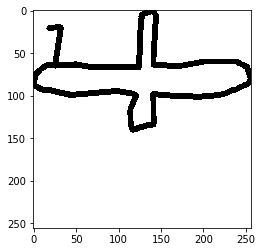

In [86]:
plt.imshow(res, cmap='Greys')

In [87]:
res2 = draw_cv2(df['drawing'][28], lw=6, size=128, time_color=False)
im_bw = cv2.threshold(res2, 127, 255, cv2.THRESH_BINARY)[1]

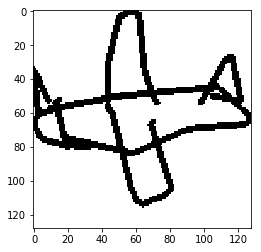

In [88]:
plt.imshow(im_bw, cmap='Greys')

In [47]:
def convert(args):
    fname, path_to_strokes, path_to_imgs = args

    try:
        # get the correct label name (replaces space w underscore)
        label = os.path.splitext(fname.replace(" ", "_"))[0]
        
        recognized_path = os.path.join(path_to_imgs, 'recognized', label)
        unrecognized_path = os.path.join(path_to_imgs, 'unrecognized', label)

        # make recognized and unrecognized directories        
        os.makedirs(recognized_path, exist_ok=True)
        os.makedirs(unrecognized_path, exist_ok=True)

        # read in csv
        df = pd.read_csv(os.path.join(path_to_strokes, fname))

        # convert strokes to list from string
        df['drawing'] = df['drawing'].apply(eval)

        # render imgs
        for i in range(len(df)):
            if df['recognized'][i] == 'True' or df['recognized'][i] == True:
                write_path = recognized_path
            else:
                write_path = unrecognized_path
                
            res = draw_cv2(df['drawing'][i], lw=6, time_color=False)
            cv2.imwrite(os.path.join(write_path, label+"_"+str(i)+".png"), res)
                
    except:
        print("Failed on:", fname)

In [48]:
def convert_all(path_to_strokes, path_to_imgs):
    arg_list = []
    for fname in list(os.walk(path_to_strokes))[0][2]:
        args = (fname, path_to_strokes, path_to_imgs)
        arg_list.append(args)
        
    pool = Pool(32)
    pool.map(convert, arg_list)
    pool.close() 
    pool.join()

In [49]:
# convert_all("../../data/stroke_data/", "../../data/img_data/")